# Lab2 

Tutorial 5 shows how to use random search to find the optimal configuration of hyperparameters and layer choices for the Bert model.
Now, explore using the GridSampler and TPESampler in Optuna.
Plot a figure that has the number of trials on the x axis, and the maximum achieved accuracy up to that point on the y axis. Plot one curve for each sampler to compare their performance.

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda:0"

In [18]:
import logging
import traceback
from pathlib import Path

save_path = "/adls/mase/docs/source/modules/documentation/tutorials/"

# 1) Configure Python's logging to write to a file (error.log)
logging.basicConfig(
    filename= "error.log",
    level=logging.ERROR,
    format='%(asctime)s %(levelname)s: %(message)s'
)

# 2) Define a custom exception hook that logs the traceback
def custom_exc(shell, etype, evalue, tb, tb_offset=None):
    # Format the traceback into a string
    exc_traceback = ''.join(traceback.format_exception(etype, evalue, tb))
    
    # Log to file
    logging.error("Unhandled exception:\n%s", exc_traceback)
    
    # Optionally print something minimal in the notebook cell
    print("An error occurred. See error.log for details.")

# 3) Register the custom exception hook with IPython
get_ipython().set_custom_exc((Exception,), custom_exc)

print("Custom exception hook installed!")


Custom exception hook installed!


In [25]:
logging.error(f"===============a sampler training is finished===============")

ERROR:root:===============a sampler training is finished===============


In [6]:
import optuna
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr


checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"


from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

## Define the search space
import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

config = AutoConfig.from_pretrained(checkpoint)
temp_model = AutoModelForSequenceClassification.from_config(config)

for name, layer in temp_model.named_modules():
    if isinstance(layer, nn.Linear):
        layer_name = f"{name}_type"
        search_space[layer_name] = [nn.Linear, Identity]

for key in search_space.keys():
    print(key)



## Write a model constructor

def get_sampler_type(trial):
    sampler_cls = type(trial.study.sampler)
    if sampler_cls is optuna.samplers.GridSampler:
        return "grid"
    elif sampler_cls is optuna.samplers.RandomSampler:
        return "random"
    elif sampler_cls is optuna.samplers.TPESampler:
        return "tpe"
    else:
        return "unknown"

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    sampler_type = get_sampler_type(trial)
    
    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:  
        if sampler_type in ["random", "tpe"]:
            chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
            setattr(config, param, search_space[param][chosen_idx])
        elif sampler_type in ["grid"]:
            chosen_value = trial.suggest_categorical(param, search_space[param])
            setattr(config, param, chosen_value)

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model


## Define the objective function
from chop.tools import get_trainer


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

# bert.encoder.layer.0.intermediate.dense_type


/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


num_layers
num_heads
hidden_size
intermediate_size
linear_layer_choices
bert.encoder.layer.0.attention.self.query_type
bert.encoder.layer.0.attention.self.key_type
bert.encoder.layer.0.attention.self.value_type
bert.encoder.layer.0.attention.output.dense_type
bert.encoder.layer.0.intermediate.dense_type
bert.encoder.layer.0.output.dense_type
bert.encoder.layer.1.attention.self.query_type
bert.encoder.layer.1.attention.self.key_type
bert.encoder.layer.1.attention.self.value_type
bert.encoder.layer.1.attention.output.dense_type
bert.encoder.layer.1.intermediate.dense_type
bert.encoder.layer.1.output.dense_type
bert.pooler.dense_type
classifier_type


In [ ]:
## Launch the search
from optuna.samplers import GridSampler, RandomSampler, TPESampler
import optuna
import copy

grid, random, tpe, = GridSampler(search_space), RandomSampler(), TPESampler()
samplers = [grid, random, tpe]

trials_record = []

for sampler in samplers:

    study = optuna.create_study(
        direction="maximize",
        study_name="bert-tiny-nas-study",
        sampler=sampler,
    )

    study.optimize(
        objective,
        n_trials=100,
        timeout=60 * 60 * 24,
    )
    
    accuracies = [trial.value for trial in study.trials]
    trials_record.append(accuracies)
    logging.error(f"===============a sampler training is finished===============")


/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/optuna/samplers/_grid.py:232: UserWarning: linear_layer_choices contains a value with the type of <class 'type'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`, `bool` or `None` for persistent storage.
  warnings.warn(message)
/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/optuna/samplers/_grid.py:232: UserWarning: bert.encoder.layer.0.attention.self.query_type contains a value with the type of <class 'type'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`, `bool` or `None` for persistent storage.
  warnings.warn(message)
/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/optuna/samplers/_grid.py:232: UserWarning: bert.encoder.layer.0.attention.self.key_type contains a value with the type of <class 'type'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`,

Step,Training Loss
500,0.673300
1000,0.490300
1500,0.408400
2000,0.379400
2500,0.320400
3000,0.350600


[I 2025-01-28 13:55:04,734] Trial 0 finished with value: 0.86136 and parameters: {'num_layers': 4, 'num_heads': 4, 'hidden_size': 384, 'intermediate_size': 2048, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with val

Step,Training Loss
500,0.655800
1000,0.476100
1500,0.404400
2000,0.369100
2500,0.326700
3000,0.342500


[I 2025-01-28 13:56:45,390] Trial 1 finished with value: 0.86612 and parameters: {'num_layers': 4, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 1024, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 1 with value:

Step,Training Loss
500,0.659000
1000,0.486900
1500,0.404000
2000,0.349100


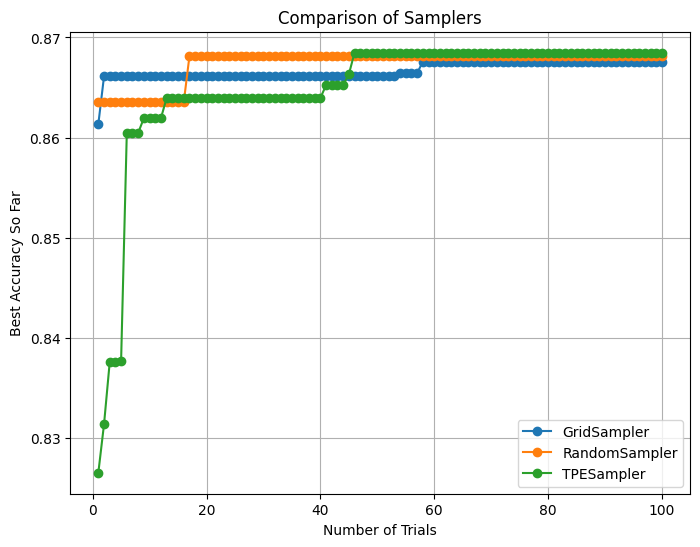

In [11]:
import math
import matplotlib.pyplot as plt
from pathlib import Path

sampler_names = ["GridSampler", "RandomSampler", "TPESampler"]
all_best_accuracies = []

for accuracies in trials_record:
    best_accuracies = []
    current_best = -math.inf

    for acc in accuracies:
        # Update current_best if we have a valid accuracy
        if acc is not None:  # (In case of Nones, otherwise you can omit this check)
            current_best = max(current_best, acc)
        best_accuracies.append(current_best)

    all_best_accuracies.append(best_accuracies)

# Plot
plt.figure(figsize=(8, 6))
for sampler_name, best_accuracies in zip(sampler_names, all_best_accuracies):
    x_values = range(1, len(best_accuracies) + 1)
    plt.plot(x_values, best_accuracies, label=sampler_name, marker='o')

plt.title("Comparison of Samplers")
plt.xlabel("Number of Trials")
plt.ylabel("Best Accuracy So Far")
plt.legend()
plt.grid(True)

save_path = "/adls/mase/docs/source/modules/documentation/tutorials/cw_submission/img"
plt.savefig(f"{Path.home()}{save_path}/sampler_comparison.png", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
import os
os._exit(0)

### Q2

In Tutorial 5, NAS is used to find an optimal configuration of hyperparameters, then we use the CompressionPipeline in Mase to quantize and prune the model after search is finished. However, the final compressed model may not be optimal, since different model architectures may have different sensitivities to quantization and pruning. Ideally, we want to run a compression-aware search flow, where the quantization and pruning is considered in each trial.

- In the objective function, after the model is constructed and trained for some iterations, call the CompressionPipeline to quantize and prune the model, then continue training for a few more epochs. Use the sampler that yielded the best results in Task 1 to run the compression-aware search. The objective function should return the final accuracy of the model after compression. Consider also the case where final training is performed after quantization/pruning.

- Plot a new figure that has the number of trials on the x axis, and the maximum achieved accuracy up to that point on the y axis. There should be three curves: 1. the best performance from Task 1 (without compression), compression-aware search without post-compression training, and compression-aware search with post-compression training.

In [3]:
import os
import optuna
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr
from chop.pipelines import CompressionPipeline
from chop import MaseGraph
import copy

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"


from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

######################################################
## Define the search space
######################################################
import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

config = AutoConfig.from_pretrained(checkpoint)
temp_model = AutoModelForSequenceClassification.from_config(config)

for name, layer in temp_model.named_modules():
    if isinstance(layer, nn.Linear):
        layer_name = f"{name}_type"
        search_space[layer_name] = [nn.Linear, Identity]

for key, value in search_space.items():
    print(key, value)

    
######################################################
## Define Compression pipeline
######################################################

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

# mg = MaseGraph(model)
# pipe = CompressionPipeline()
# mg, _ = pipe(
#     mg,
#     pass_args={
#         "quantize_transform_pass": quantization_config,
#         "prune_transform_pass": pruning_config,
#     },
# )

    
######################################################
## Write a model constructor
######################################################

def get_sampler_type(trial):
    sampler_cls = type(trial.study.sampler)
    if sampler_cls is optuna.samplers.GridSampler:
        return "grid"
    elif sampler_cls is optuna.samplers.RandomSampler:
        return "random"
    elif sampler_cls is optuna.samplers.TPESampler:
        return "tpe"
    else:
        return "unknown"

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    sampler_type = get_sampler_type(trial)
    
    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:  
        if sampler_type in ["random", "tpe"]:
            chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
            setattr(config, param, search_space[param][chosen_idx])
        elif sampler_type in ["grid"]:
            chosen_value = trial.suggest_categorical(param, search_space[param])
            setattr(config, param, chosen_value)

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")
    
    return trial_model

######################################################
## Define the objective function
######################################################

from chop.tools import get_trainer


def objective_nocomp(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=3,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    
    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)
    
    return eval_results["eval_accuracy"]


########################################
def objective_comp(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=3,
    )
    trainer.train()
    
    # add compression pipeline and further training
    model.to("cpu")
    mg = MaseGraph(
        model,
        hf_input_names=[
            "input_ids",
            "attention_mask",
            "labels",
        ],
    )
    pipe = CompressionPipeline()
    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": copy.deepcopy(quantization_config),
            "prune_transform_pass": copy.deepcopy(pruning_config),
        },
    )
    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )
    eval_results = trainer.evaluate()
    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)
    
    return eval_results["eval_accuracy"]

#########################################
def objective_comptrain(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=3,
    )
    trainer.train()

    # add compression pipeline and further training
    model.to("cpu")
    mg = MaseGraph(
        model,
        hf_input_names=[
            "input_ids",
            "attention_mask",
            "labels",
        ],
    )
    pipe = CompressionPipeline()
    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": copy.deepcopy(quantization_config),
            "prune_transform_pass": copy.deepcopy(pruning_config),
        },
    )
    
    # further finetune
    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=2,
    )
    trainer.train()
    eval_results = trainer.evaluate()
    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)
    
    return eval_results["eval_accuracy"]


obj_dict = {
    "nocomp": objective_nocomp,
    "comp": objective_comp,
    "comptrain": objective_comptrain,
}


/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


num_layers [2, 4, 8]
num_heads [2, 4, 8, 16]
hidden_size [128, 192, 256, 384, 512]
intermediate_size [512, 768, 1024, 1536, 2048]
linear_layer_choices [<class 'torch.nn.modules.linear.Linear'>, <class 'chop.nn.modules.identity.Identity'>]
bert.encoder.layer.0.attention.self.query_type [<class 'torch.nn.modules.linear.Linear'>, <class 'chop.nn.modules.identity.Identity'>]
bert.encoder.layer.0.attention.self.key_type [<class 'torch.nn.modules.linear.Linear'>, <class 'chop.nn.modules.identity.Identity'>]
bert.encoder.layer.0.attention.self.value_type [<class 'torch.nn.modules.linear.Linear'>, <class 'chop.nn.modules.identity.Identity'>]
bert.encoder.layer.0.attention.output.dense_type [<class 'torch.nn.modules.linear.Linear'>, <class 'chop.nn.modules.identity.Identity'>]
bert.encoder.layer.0.intermediate.dense_type [<class 'torch.nn.modules.linear.Linear'>, <class 'chop.nn.modules.identity.Identity'>]
bert.encoder.layer.0.output.dense_type [<class 'torch.nn.modules.linear.Linear'>, <class

In [ ]:
## Launch the search
from optuna.samplers import GridSampler, RandomSampler, TPESampler
import optuna
import copy

grid, random, tpe, = GridSampler(search_space), RandomSampler(), TPESampler()
sampler = tpe
trials_record = []

for obj_type in ["nocomp", "comp", "comptrain"]:
    study = optuna.create_study(
        direction="maximize",
        study_name="bert-tiny-nas-study",
        sampler=sampler,
    )

    study.optimize(
        obj_dict[obj_type],
        n_trials=70,
        timeout=60 * 60 * 24,
    )

    accuracies = [trial.value for trial in study.trials]
    trials_record.append(accuracies)
    logging.error(f"===============a sampler training is finished===============")


/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/optuna/samplers/_grid.py:232: UserWarning: linear_layer_choices contains a value with the type of <class 'type'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`, `bool` or `None` for persistent storage.
  warnings.warn(message)
/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/optuna/samplers/_grid.py:232: UserWarning: bert.encoder.layer.0.attention.self.query_type contains a value with the type of <class 'type'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`, `bool` or `None` for persistent storage.
  warnings.warn(message)
/home/jw3621/anaconda3/envs/mase-adls/lib/python3.11/site-packages/optuna/samplers/_grid.py:232: UserWarning: bert.encoder.layer.0.attention.self.key_type contains a value with the type of <class 'type'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`,

Step,Training Loss
500,0.693800
1000,0.575400
1500,0.488600
2000,0.404700
2500,0.366900
3000,0.377900
3500,0.319000
4000,0.290800
4500,0.297600
5000,0.307500


[I 2025-02-07 13:12:58,354] Trial 0 finished with value: 0.87544 and parameters: {'num_layers': 1, 'num_heads': 3, 'hidden_size': 1, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with value

Step,Training Loss
500,0.694300
1000,0.673000
1500,0.523100
2000,0.459400
2500,0.436400
3000,0.416100
3500,0.385000
4000,0.344300
4500,0.341300
5000,0.339700


[I 2025-02-07 13:15:40,966] Trial 1 finished with value: 0.87296 and parameters: {'num_layers': 1, 'num_heads': 2, 'hidden_size': 0, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 

Step,Training Loss
500,0.663400
1000,0.469600
1500,0.402500
2000,0.368500
2500,0.354500
3000,0.370400
3500,0.290800
4000,0.274600
4500,0.283900
5000,0.286400


#### Diagram Plotting

[[0.87544, 0.87296, 0.87812, 0.87504, 0.87952, 0.8776, 0.87724, 0.87728, 0.87752, 0.88, 0.87852, 0.87748, 0.87988, 0.87992, 0.88192, 0.8844, 0.87988, 0.8844, 0.87732, 0.87764, 0.8844, 0.8844, 0.88004, 0.88, 0.87728, 0.87996, 0.87944, 0.87812, 0.87908, 0.88028, 0.88172, 0.8844, 0.8844, 0.87728, 0.87068, 0.87868, 0.8802, 0.87676, 0.87952, 0.87652, 0.8762, 0.8844, 0.8844, 0.87728, 0.87916, 0.88032, 0.8762, 0.88028, 0.87992, 0.88184, 0.87964, 0.8844, 0.8844, 0.8844, 0.8844, 0.8844, 0.88244, 0.8772, 0.8774, 0.87808, 0.88148, 0.8844, 0.8844, 0.8844, 0.8844, 0.8844, 0.88216, 0.875, 0.87912, 0.88164], [0.71252, 0.8266, 0.76744, 0.8632, 0.77728, 0.8298, 0.85912, 0.86408, 0.84592, 0.8586, 0.8656, 0.86568, 0.86568, 0.86564, 0.86452, 0.86512, 0.85968, 0.86184, 0.8696, 0.84524, 0.8696, 0.86964, 0.86948, 0.86932, 0.8268, 0.86948, 0.74992, 0.86956, 0.8452, 0.74992, 0.80312, 0.86916, 0.86936, 0.86928, 0.73772, 0.82588, 0.84128, 0.86332, 0.84668, 0.87108, 0.82952, 0.87228, 0.86312, 0.87252, 0.87204, 0.

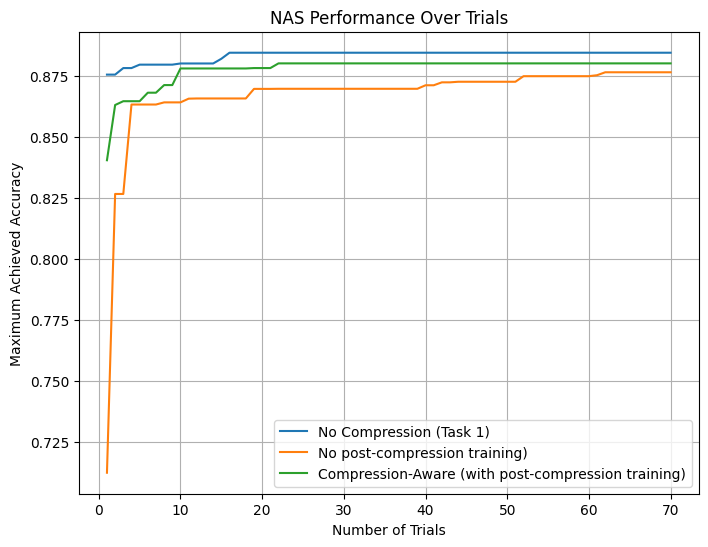

In [9]:
import matplotlib.pyplot as plt

# Suppose you already have something like this from your searches:
# trials_record = [
#    [acc_trial_1, acc_trial_2, ..., acc_trial_N],  # no compression
#    [acc_trial_1, acc_trial_2, ..., acc_trial_N],  # comp-aware, no post-comp training
#    [acc_trial_1, acc_trial_2, ..., acc_trial_N],  # comp-aware, with post-comp training
# ]

print(trials_record)

# 1. Compute the running maximum for each condition
max_acc_list = []
for accuracies in trials_record:
    running_max = []
    current_max = float('-inf')
    for acc in accuracies:
        current_max = max(current_max, acc)
        running_max.append(current_max)
    max_acc_list.append(running_max)

# 2. Plot the results
plt.figure(figsize=(8, 6))

num_trials_nocomp = len(max_acc_list[0])
num_trials_comp   = len(max_acc_list[1])
num_trials_ctrain = len(max_acc_list[2])

# X-axes for each plot (use 1-based indexing for clarity)
x_nocomp   = range(1, num_trials_nocomp + 1)
x_comp     = range(1, num_trials_comp + 1)
x_ctrain   = range(1, num_trials_ctrain + 1)

plt.plot(x_nocomp,   max_acc_list[0], label="No Compression (Task 1)")
plt.plot(x_comp,     max_acc_list[1], label="No post-compression training)")
plt.plot(x_ctrain,   max_acc_list[2], label="Compression-Aware (with post-compression training)")

plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("NAS Performance Over Trials")
plt.legend()
plt.grid(True)

save_path = "/adls/mase/docs/source/modules/documentation/tutorials/cw_submission/img"
plt.savefig(f"{Path.home()}{save_path}/compression-aware-search.png", dpi=300, bbox_inches="tight")

plt.show()


In [11]:
import json

# 1. Saving the data to a JSON file:
with open("trials_record.json", "w") as f:
    json.dump(trials_record, f)

# 2. Loading the data back from the JSON file:
with open("trials_record.json", "r") as f:
    loaded_data = json.load(f)

print("Loaded data:", loaded_data)


Loaded data: [[0.87544, 0.87296, 0.87812, 0.87504, 0.87952, 0.8776, 0.87724, 0.87728, 0.87752, 0.88, 0.87852, 0.87748, 0.87988, 0.87992, 0.88192, 0.8844, 0.87988, 0.8844, 0.87732, 0.87764, 0.8844, 0.8844, 0.88004, 0.88, 0.87728, 0.87996, 0.87944, 0.87812, 0.87908, 0.88028, 0.88172, 0.8844, 0.8844, 0.87728, 0.87068, 0.87868, 0.8802, 0.87676, 0.87952, 0.87652, 0.8762, 0.8844, 0.8844, 0.87728, 0.87916, 0.88032, 0.8762, 0.88028, 0.87992, 0.88184, 0.87964, 0.8844, 0.8844, 0.8844, 0.8844, 0.8844, 0.88244, 0.8772, 0.8774, 0.87808, 0.88148, 0.8844, 0.8844, 0.8844, 0.8844, 0.8844, 0.88216, 0.875, 0.87912, 0.88164], [0.71252, 0.8266, 0.76744, 0.8632, 0.77728, 0.8298, 0.85912, 0.86408, 0.84592, 0.8586, 0.8656, 0.86568, 0.86568, 0.86564, 0.86452, 0.86512, 0.85968, 0.86184, 0.8696, 0.84524, 0.8696, 0.86964, 0.86948, 0.86932, 0.8268, 0.86948, 0.74992, 0.86956, 0.8452, 0.74992, 0.80312, 0.86916, 0.86936, 0.86928, 0.73772, 0.82588, 0.84128, 0.86332, 0.84668, 0.87108, 0.82952, 0.87228, 0.86312, 0.87252